<a href="https://colab.research.google.com/github/NOBODIDI/APS360_GeoGuessr_NN/blob/main/primary_model/Liza's_Tuning_(ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful Links

*   Background info: https://cs231n.github.io/transfer-learning/
*   https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* Finetuning: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html




REMEMBER TO CHANGE RUNTIME TO GPU AND THEN MOUNT GOOGLE DRIVE (ALSO ADD TRAIN_VAL_TEST_SPLIT AS A SHORTCUT TO DRIVE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import shutil
import time
import copy

### Initializing Model

In [ ]:
def init_model(model_name):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    net = None
    input_size = 0

    if model_name == "resnet":
        """ WideResnet50 
        https://pytorch.org/vision/master/models/generated/torchvision.models.wide_resnet50_2.html#torchvision.models.wide_resnet50_2
        """
        net = models.wide_resnet50_2(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = True
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "resnet50":
        """ Resnet50 
        https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
        """
        net = models.resnet50(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = False
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'mobilenet':
        """ MobileNetV3 Small
        https://pytorch.org/vision/stable/models/generated/torchvision.models.mobilenet_v3_small.html#torchvision.models.mobilenet_v3_small
        """
        net = torchvision.models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.IMAGENET1K_V1')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
              param.requires_grad = False
        num_ftrs = net.classifier[3].in_features
        net.classifier[3] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "alexnet":
        """ Alexnet
        https://pytorch.org/vision/master/models/generated/torchvision.models.alexnet.html#torchvision.models.alexnet
        """
        net = models.alexnet(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = False
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "vgg":
        """ VGG11_bn
        https://pytorch.org/vision/master/models/generated/torchvision.models.vgg11_bn.html#torchvision.models.vgg11_bn
        """
        net = models.vgg11_bn(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = False
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        https://pytorch.org/vision/master/models/generated/torchvision.models.inception_v3.html#torchvision.models.inception_v3
        """
        net = models.inception_v3(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = True
        # Handle the auxilary net
        num_ftrs = net.AuxLogits.fc.in_features
        net.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs,num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    # Choosing which parameter gradients to optimize (only at the final FC layers)
    params_to_update = []
    print("Params to learn:")
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name,len(param))

    return net, params_to_update

#### Datasets and Dataloaders (Run ONCE)

In [ ]:
# Loading in Data

# /////////// CHANGE THIS TO TRUE IF YOU WANT TO USE INCEPTION /////////
is_inception = False
# /////////////////////////////////////////////////////////
if is_inception:
    resize = 342
    input_size = 299
else:
    resize = 256
    input_size = 224

# Data augmentation and normalization for training
# Just normalization for validation, test

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# ////////////////// CHANGE THIS IF NEEDED TO POINT TO THE DATA ////////////////////////
root_path = "/content/drive/MyDrive/32k_train_val_test"
# ////////////////////////////////////////////////////////////////////////////////

# Fixed PyTorch random seed for reproducible result
torch.manual_seed(1000)

# Create training and validation and test datasets
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(root_path, x), 
                                                      data_transforms[x]) for x in ['train', 'val','test']}

classes = image_datasets['train'].classes
# Number of classes
num_classes = len(classes)
print("Total dataset:",len(image_datasets['train'])+len(image_datasets['val'])+len(image_datasets['test']),"\n",
      "\tTrain size:",len(image_datasets['train']),"\n\tVal size:",len(image_datasets['val']),"\n\tTest size:",len(image_datasets['test']))
print("Number of classes:",num_classes)

batch_size = 64
# Create training and validation and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, 
                                                   shuffle=True, num_workers=1) for x in ['train', 'val','test']}

Total dataset: 32000 
 	Train size: 22400 
	Val size: 4800 
	Test size: 4800
Number of classes: 80


### Visualizing sample data (Run ONCE)

Images size: torch.Size([64, 3, 224, 224])
Labels size: torch.Size([64])


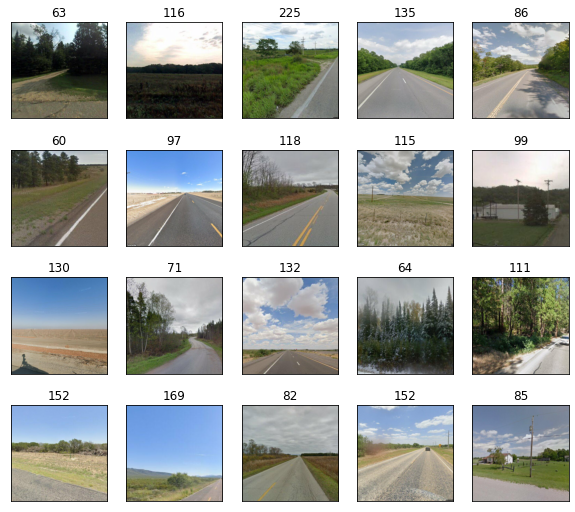

In [ ]:
# Visualize some sample data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp[0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# # obtain one batch of training images
images, labels = next(iter(dataloaders_dict['train']))
print("Images size:",images.shape)
print("Labels size:",labels.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 9))
for i in np.arange(20):
    ax = fig.add_subplot(4, 20/4, i+1, xticks=[], yticks=[])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = images[i].numpy().transpose((1,2,0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    ax.set_title(classes[labels[i]])

### Training the Model

In [ ]:
# Training code modified from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def train_model(model, model_name,
                datasets=image_datasets, 
                batch_size=256, 
                learning_rate=0.045, 
                halving_time=10,
                weight_decay=1e-6,
                num_epochs=5, 
                aux_coef=0.4, # Inception auxiliary coefficient
                is_inception=False):
  
    since = time.time()
    # ////////////////// CHANGE THIS IF NEEDED TO POINT to your SAVE FOLDER ////////////////////////
    save_path = "/content/drive/MyDrive/ResNet50 Results"
    # ////////////////////////////////////////////////////////////////////////////////
    model_path = os.path.join(save_path, "best_32k_unfrozen_model_{0}_bs{1}_lr{2}_ht{3}_wd{4}_epochs{5}".format(model_name,
                                                                                      batch_size,
                                                                                      learning_rate,
                                                                                      halving_time,
                                                                                      weight_decay,
                                                                                      num_epochs))

    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 
                                                  batch_size=batch_size, 
                                                  shuffle=True, 
                                                  num_workers=4) for x in ['train', 'val']}

    # Observe that some parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=learning_rate, weight_decay=weight_decay)
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    val_loss_history = []
    val_acc_history = []
    train_loss_history = []
    train_acc_history = []
    epochs = np.arange(0,num_epochs)

    best_acc = 0.0

    for epoch in range(num_epochs):
        # start_epoch = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Learning Rate schedule
        if ((epoch) % (halving_time) == 0) and (epoch != 0):
          learning_rate /= 2
          optimizer = optim.Adam(params_to_update, lr=learning_rate, weight_decay=weight_decay)
          print('////// NEW LEARNING RATE: {:.4f} //////'.format(learning_rate))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            i = 0
            for inputs, labels in dataloaders[phase]:

                #############################################
                #To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                  labels = labels.cuda()
                #############################################

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for the loss by summing the final output and the auxiliary output
                    #   but in testing inception because in training it has an auxiliary output. In train
                    #   mode we calculate  only consider the final output.
                    if phase == 'train' and is_inception == True:
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + aux_coef*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # ///////// UNCOMMENT IF YOU WANT TO SEE RUNNING LOSS ///////////////////////////
                #time_elapsed = time.time() - since
                #print('{}: {} Running Loss: {:.4f} Running Acc: {:.4f} Time elapsed:{:.0f}m {:.0f}s'.format(i, phase, running_loss, running_corrects, time_elapsed // 60, time_elapsed % 60))
                i+=1

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), model_path)
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        time_elapsed = time.time() - since
        print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
        print('-' * 10)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    plt.title("Training vs Validation Loss Curve")
    plt.plot(epochs, train_loss_history, label="Train")
    plt.plot(epochs, val_loss_history, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training vs Validation Accuracy Curve")
    plt.plot(epochs, train_acc_history, label="Train")
    plt.plot(epochs, val_acc_history, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # load best model weights
    state = torch.load(model_path)
    model.load_state_dict(state)
    return model

## Training Model

Params to learn:
	 conv1.weight 64
	 bn1.weight 64
	 bn1.bias 64
	 layer1.0.conv1.weight 64
	 layer1.0.bn1.weight 64
	 layer1.0.bn1.bias 64
	 layer1.0.conv2.weight 64
	 layer1.0.bn2.weight 64
	 layer1.0.bn2.bias 64
	 layer1.0.conv3.weight 256
	 layer1.0.bn3.weight 256
	 layer1.0.bn3.bias 256
	 layer1.0.downsample.0.weight 256
	 layer1.0.downsample.1.weight 256
	 layer1.0.downsample.1.bias 256
	 layer1.1.conv1.weight 64
	 layer1.1.bn1.weight 64
	 layer1.1.bn1.bias 64
	 layer1.1.conv2.weight 64
	 layer1.1.bn2.weight 64
	 layer1.1.bn2.bias 64
	 layer1.1.conv3.weight 256
	 layer1.1.bn3.weight 256
	 layer1.1.bn3.bias 256
	 layer1.2.conv1.weight 64
	 layer1.2.bn1.weight 64
	 layer1.2.bn1.bias 64
	 layer1.2.conv2.weight 64
	 layer1.2.bn2.weight 64
	 layer1.2.bn2.bias 64
	 layer1.2.conv3.weight 256
	 layer1.2.bn3.weight 256
	 layer1.2.bn3.bias 256
	 layer2.0.conv1.weight 128
	 layer2.0.bn1.weight 128
	 layer2.0.bn1.bias 128
	 layer2.0.conv2.weight 128
	 layer2.0.bn2.weight 128
	 layer2.0.bn2.b

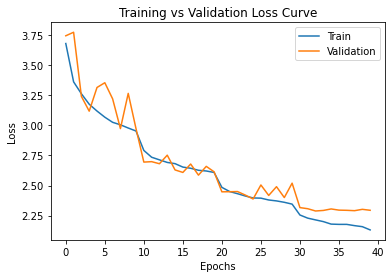

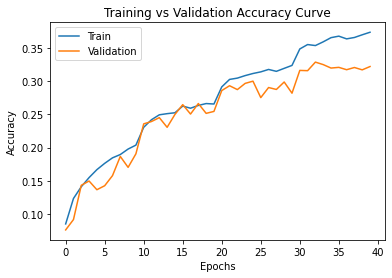

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'resnet50' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True
print("GPU on!")

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name,
                            datasets=image_datasets, 
                            batch_size=64, 
                            learning_rate=0.001, 
                            halving_time=10,
                            weight_decay=1e-3,
                            num_epochs=40)

Params to learn:
	 conv1.weight 64
	 bn1.weight 64
	 bn1.bias 64
	 layer1.0.conv1.weight 64
	 layer1.0.bn1.weight 64
	 layer1.0.bn1.bias 64
	 layer1.0.conv2.weight 64
	 layer1.0.bn2.weight 64
	 layer1.0.bn2.bias 64
	 layer1.0.conv3.weight 256
	 layer1.0.bn3.weight 256
	 layer1.0.bn3.bias 256
	 layer1.0.downsample.0.weight 256
	 layer1.0.downsample.1.weight 256
	 layer1.0.downsample.1.bias 256
	 layer1.1.conv1.weight 64
	 layer1.1.bn1.weight 64
	 layer1.1.bn1.bias 64
	 layer1.1.conv2.weight 64
	 layer1.1.bn2.weight 64
	 layer1.1.bn2.bias 64
	 layer1.1.conv3.weight 256
	 layer1.1.bn3.weight 256
	 layer1.1.bn3.bias 256
	 layer1.2.conv1.weight 64
	 layer1.2.bn1.weight 64
	 layer1.2.bn1.bias 64
	 layer1.2.conv2.weight 64
	 layer1.2.bn2.weight 64
	 layer1.2.bn2.bias 64
	 layer1.2.conv3.weight 256
	 layer1.2.bn3.weight 256
	 layer1.2.bn3.bias 256
	 layer2.0.conv1.weight 128
	 layer2.0.bn1.weight 128
	 layer2.0.bn1.bias 128
	 layer2.0.conv2.weight 128
	 layer2.0.bn2.weight 128
	 layer2.0.bn2.b

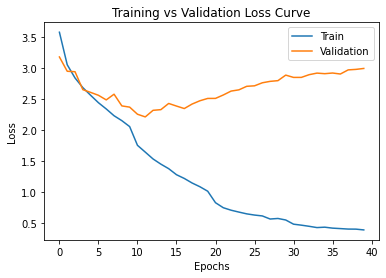

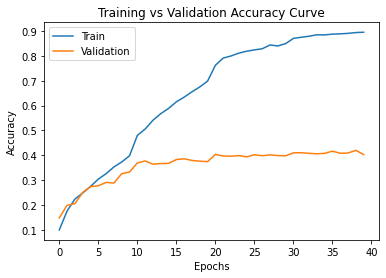

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'resnet50' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True
print("GPU on!")

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name,
                            datasets=image_datasets, 
                            batch_size=64, 
                            learning_rate=0.001, 
                            halving_time=10,
                            weight_decay=1e-6,
                            num_epochs=40)

Streaming output truncated to the last 5000 lines.
173: train Running Loss: 6338.5263 Running Acc: 9362.0000 Time elapsed:52m 10s
174: train Running Loss: 6375.7342 Running Acc: 9414.0000 Time elapsed:52m 10s
175: train Running Loss: 6417.4002 Running Acc: 9461.0000 Time elapsed:52m 10s
176: train Running Loss: 6462.8070 Running Acc: 9513.0000 Time elapsed:52m 11s
177: train Running Loss: 6489.6827 Running Acc: 9569.0000 Time elapsed:52m 11s
178: train Running Loss: 6512.2802 Running Acc: 9626.0000 Time elapsed:52m 11s
179: train Running Loss: 6555.0148 Running Acc: 9674.0000 Time elapsed:52m 11s
180: train Running Loss: 6603.5958 Running Acc: 9726.0000 Time elapsed:52m 12s
181: train Running Loss: 6654.6882 Running Acc: 9777.0000 Time elapsed:52m 12s
182: train Running Loss: 6699.5096 Running Acc: 9829.0000 Time elapsed:52m 12s
183: train Running Loss: 6728.5406 Running Acc: 9886.0000 Time elapsed:52m 12s
184: train Running Loss: 6763.8231 Running Acc: 9939.0000 Time elapsed:52m 12s
1

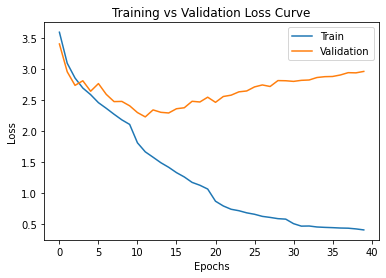

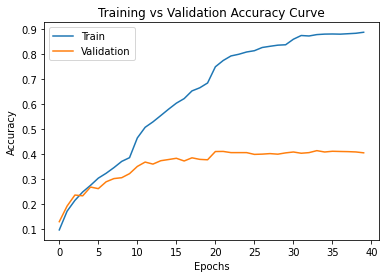

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'resnet50' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True
print("GPU on!")

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name,
                            datasets=image_datasets, 
                            batch_size=64, 
                            learning_rate=0.001, 
                            halving_time=10,
                            num_epochs=40)

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'resnet50' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True
print("GPU on!")

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name,
                            datasets=image_datasets, 
                            batch_size=64, 
                            learning_rate=0.001, 
                            halving_time=15,
                            num_epochs=30)

Params to learn:
	 conv1.weight 64
	 bn1.weight 64
	 bn1.bias 64
	 layer1.0.conv1.weight 64
	 layer1.0.bn1.weight 64
	 layer1.0.bn1.bias 64
	 layer1.0.conv2.weight 64
	 layer1.0.bn2.weight 64
	 layer1.0.bn2.bias 64
	 layer1.0.conv3.weight 256
	 layer1.0.bn3.weight 256
	 layer1.0.bn3.bias 256
	 layer1.0.downsample.0.weight 256
	 layer1.0.downsample.1.weight 256
	 layer1.0.downsample.1.bias 256
	 layer1.1.conv1.weight 64
	 layer1.1.bn1.weight 64
	 layer1.1.bn1.bias 64
	 layer1.1.conv2.weight 64
	 layer1.1.bn2.weight 64
	 layer1.1.bn2.bias 64
	 layer1.1.conv3.weight 256
	 layer1.1.bn3.weight 256
	 layer1.1.bn3.bias 256
	 layer1.2.conv1.weight 64
	 layer1.2.bn1.weight 64
	 layer1.2.bn1.bias 64
	 layer1.2.conv2.weight 64
	 layer1.2.bn2.weight 64
	 layer1.2.bn2.bias 64
	 layer1.2.conv3.weight 256
	 layer1.2.bn3.weight 256
	 layer1.2.bn3.bias 256
	 layer2.0.conv1.weight 128
	 layer2.0.bn1.weight 128
	 layer2.0.bn1.bias 128
	 layer2.0.conv2.weight 128
	 layer2.0.bn2.weight 128
	 layer2.0.bn2.b

Params to learn:
	 fc.weight 80
	 fc.bias 80
GPU on!
CUDA is available!  Training on GPU ...
Epoch 0/39
----------
train Loss: 3.8950 Acc: 0.0826
val Loss: 3.5843 Acc: 0.1148
Time elapsed: 2m 32s
----------
Epoch 1/39
----------
train Loss: 3.4861 Acc: 0.1498
val Loss: 3.4224 Acc: 0.1431
Time elapsed: 5m 3s
----------
Epoch 2/39
----------
train Loss: 3.3136 Acc: 0.1776
val Loss: 3.3327 Acc: 0.1590
Time elapsed: 7m 34s
----------
Epoch 3/39
----------
train Loss: 3.2001 Acc: 0.1968
val Loss: 3.2665 Acc: 0.1683
Time elapsed: 10m 3s
----------
Epoch 4/39
----------
train Loss: 3.1186 Acc: 0.2121
val Loss: 3.2642 Acc: 0.1727
Time elapsed: 12m 34s
----------
Epoch 5/39
----------
train Loss: 3.0567 Acc: 0.2244
val Loss: 3.2204 Acc: 0.1775
Time elapsed: 15m 4s
----------
Epoch 6/39
----------
train Loss: 2.9951 Acc: 0.2400
val Loss: 3.2069 Acc: 0.1808
Time elapsed: 17m 33s
----------
Epoch 7/39
----------
train Loss: 2.9484 Acc: 0.2508
val Loss: 3.1951 Acc: 0.1827
Time elapsed: 20m 3s
-----

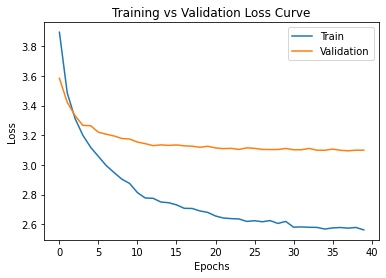

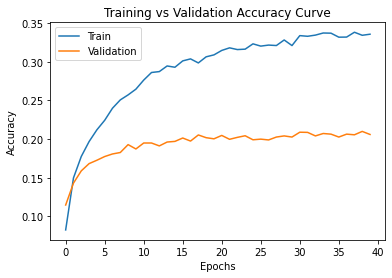

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'resnet50' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True
print("GPU on!")

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name,
                            datasets=image_datasets, 
                            batch_size=128, 
                            learning_rate=0.002, 
                            halving_time=10,
                            num_epochs=40)

In [ ]:
print('hello')

hello


In [ ]:
print('goodbye')

goodbye


Params to learn:
	 fc.weight 80
	 fc.bias 80
GPU on!
CUDA is available!  Training on GPU ...
Epoch 0/9
----------
0: train Running Loss: 1124.8953 Running Acc: 1.0000 Time elapsed:0m 35s
1: train Running Loss: 2246.1298 Running Acc: 3.0000 Time elapsed:0m 36s
2: train Running Loss: 3367.7430 Running Acc: 8.0000 Time elapsed:0m 37s
3: train Running Loss: 4488.7341 Running Acc: 10.0000 Time elapsed:0m 38s
4: train Running Loss: 5598.4296 Running Acc: 16.0000 Time elapsed:1m 7s
5: train Running Loss: 6713.6498 Running Acc: 26.0000 Time elapsed:1m 7s
6: train Running Loss: 7836.3240 Running Acc: 33.0000 Time elapsed:1m 8s
7: train Running Loss: 8947.5525 Running Acc: 41.0000 Time elapsed:1m 9s
8: train Running Loss: 10048.7034 Running Acc: 48.0000 Time elapsed:1m 38s
9: train Running Loss: 11153.8586 Running Acc: 59.0000 Time elapsed:1m 39s
10: train Running Loss: 12260.5762 Running Acc: 73.0000 Time elapsed:1m 40s
11: train Running Loss: 13359.2593 Running Acc: 88.0000 Time elapsed:1m 41s

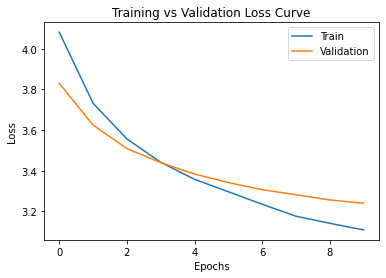

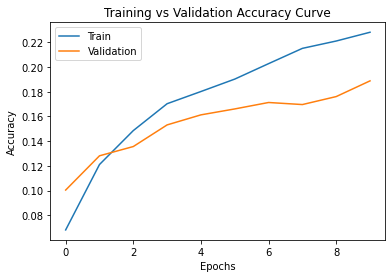

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'resnet50' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True
print("GPU on!")

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name,
                            datasets=image_datasets, 
                            batch_size=256, 
                            learning_rate=0.001, 
                            halving_time=20,
                            num_epochs=10)

Params to learn:
	 conv1.weight 64
	 bn1.weight 64
	 bn1.bias 64
	 layer1.0.conv1.weight 64
	 layer1.0.bn1.weight 64
	 layer1.0.bn1.bias 64
	 layer1.0.conv2.weight 64
	 layer1.0.bn2.weight 64
	 layer1.0.bn2.bias 64
	 layer1.0.conv3.weight 256
	 layer1.0.bn3.weight 256
	 layer1.0.bn3.bias 256
	 layer1.0.downsample.0.weight 256
	 layer1.0.downsample.1.weight 256
	 layer1.0.downsample.1.bias 256
	 layer1.1.conv1.weight 64
	 layer1.1.bn1.weight 64
	 layer1.1.bn1.bias 64
	 layer1.1.conv2.weight 64
	 layer1.1.bn2.weight 64
	 layer1.1.bn2.bias 64
	 layer1.1.conv3.weight 256
	 layer1.1.bn3.weight 256
	 layer1.1.bn3.bias 256
	 layer1.2.conv1.weight 64
	 layer1.2.bn1.weight 64
	 layer1.2.bn1.bias 64
	 layer1.2.conv2.weight 64
	 layer1.2.bn2.weight 64
	 layer1.2.bn2.bias 64
	 layer1.2.conv3.weight 256
	 layer1.2.bn3.weight 256
	 layer1.2.bn3.bias 256
	 layer2.0.conv1.weight 128
	 layer2.0.bn1.weight 128
	 layer2.0.bn1.bias 128
	 layer2.0.conv2.weight 128
	 layer2.0.bn2.weight 128
	 layer2.0.bn2.b

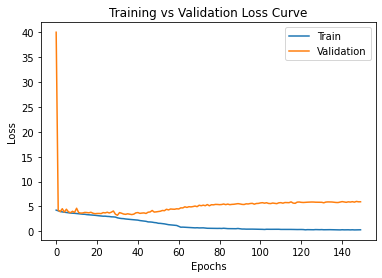

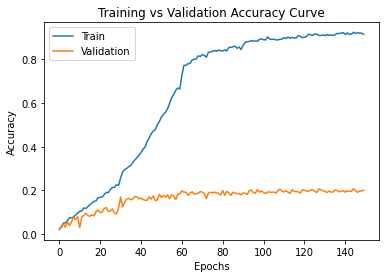

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'resnet50' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True
print("GPU on!)

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name,
                            datasets=image_datasets, 
                            batch_size=128, 
                            learning_rate=0.005, 
                            halving_time=30,
                            num_epochs=150)

Params to learn:
	 conv1.weight 64
	 bn1.weight 64
	 bn1.bias 64
	 layer1.0.conv1.weight 64
	 layer1.0.bn1.weight 64
	 layer1.0.bn1.bias 64
	 layer1.0.conv2.weight 64
	 layer1.0.bn2.weight 64
	 layer1.0.bn2.bias 64
	 layer1.0.conv3.weight 256
	 layer1.0.bn3.weight 256
	 layer1.0.bn3.bias 256
	 layer1.0.downsample.0.weight 256
	 layer1.0.downsample.1.weight 256
	 layer1.0.downsample.1.bias 256
	 layer1.1.conv1.weight 64
	 layer1.1.bn1.weight 64
	 layer1.1.bn1.bias 64
	 layer1.1.conv2.weight 64
	 layer1.1.bn2.weight 64
	 layer1.1.bn2.bias 64
	 layer1.1.conv3.weight 256
	 layer1.1.bn3.weight 256
	 layer1.1.bn3.bias 256
	 layer1.2.conv1.weight 64
	 layer1.2.bn1.weight 64
	 layer1.2.bn1.bias 64
	 layer1.2.conv2.weight 64
	 layer1.2.bn2.weight 64
	 layer1.2.bn2.bias 64
	 layer1.2.conv3.weight 256
	 layer1.2.bn3.weight 256
	 layer1.2.bn3.bias 256
	 layer2.0.conv1.weight 128
	 layer2.0.bn1.weight 128
	 layer2.0.bn1.bias 128
	 layer2.0.conv2.weight 128
	 layer2.0.bn2.weight 128
	 layer2.0.bn2.b

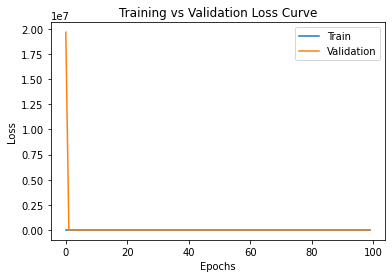

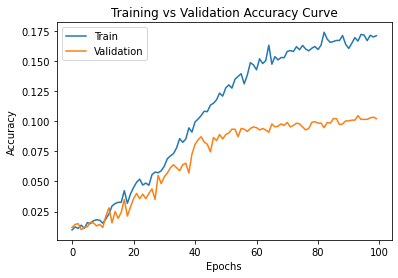

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'resnet50' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True
print("GPU on!")

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name,
                            datasets=image_datasets, 
                            batch_size=256, 
                            learning_rate=0.045, 
                            halving_time=10,
                            num_epochs=100)

Params to learn:
	 conv1.weight 64
	 bn1.weight 64
	 bn1.bias 64
	 layer1.0.conv1.weight 64
	 layer1.0.bn1.weight 64
	 layer1.0.bn1.bias 64
	 layer1.0.conv2.weight 64
	 layer1.0.bn2.weight 64
	 layer1.0.bn2.bias 64
	 layer1.0.conv3.weight 256
	 layer1.0.bn3.weight 256
	 layer1.0.bn3.bias 256
	 layer1.0.downsample.0.weight 256
	 layer1.0.downsample.1.weight 256
	 layer1.0.downsample.1.bias 256
	 layer1.1.conv1.weight 64
	 layer1.1.bn1.weight 64
	 layer1.1.bn1.bias 64
	 layer1.1.conv2.weight 64
	 layer1.1.bn2.weight 64
	 layer1.1.bn2.bias 64
	 layer1.1.conv3.weight 256
	 layer1.1.bn3.weight 256
	 layer1.1.bn3.bias 256
	 layer1.2.conv1.weight 64
	 layer1.2.bn1.weight 64
	 layer1.2.bn1.bias 64
	 layer1.2.conv2.weight 64
	 layer1.2.bn2.weight 64
	 layer1.2.bn2.bias 64
	 layer1.2.conv3.weight 256
	 layer1.2.bn3.weight 256
	 layer1.2.bn3.bias 256
	 layer2.0.conv1.weight 128
	 layer2.0.bn1.weight 128
	 layer2.0.bn1.bias 128
	 layer2.0.conv2.weight 128
	 layer2.0.bn2.weight 128
	 layer2.0.bn2.b

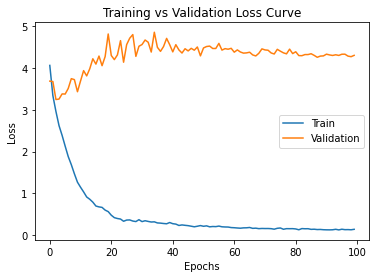

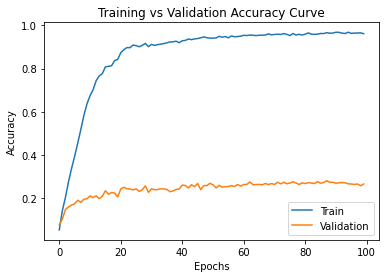

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'resnet50' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True
print("GPU on!")

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name,
                            datasets=image_datasets, 
                            batch_size=256, 
                            learning_rate=0.001, 
                            halving_time=20,
                            num_epochs=100)

## Testing Model


In [ ]:
def test_model(model,  
               datasets=image_datasets, 
               batch_size=256 ):
  
    since = time.time()
    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 
                                                  batch_size=batch_size, 
                                                  shuffle=True, 
                                                  num_workers=4) for x in ['test']}

    model.eval()   # Set model to evaluate mode
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders['test']:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################

        # Get model outputs and calculate loss
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    test_acc = float(running_corrects) / len(dataloaders['test'].dataset)

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Test Acc: {:4f}'.format(test_acc))

    return

In [ ]:
# Path to model with the hightest preliminary training accuracy
model_path = "/content/drive/MyDrive/ResNet50 Results/Best model/best_32k_unfrozen_model_resnet50_bs64_lr0.001_ht10_wd1e-06_epochs40"
# Create model instance
trained_model = models.resnet50()
num_ftrs = trained_model.fc.in_features
trained_model.fc = nn.Linear(num_ftrs, 80)

# Load trained weights
trained_model.load_state_dict(torch.load(model_path))

use_cuda = True
if use_cuda and torch.cuda.is_available():
  trained_model = trained_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

test_model(trained_model, datasets=image_datasets, batch_size=32)

CUDA is available!  Training on GPU ...
Testing complete in 1m 15s
Test Acc: 0.413125
